In [1]:
#from https://www.datacamp.com/community/tutorials/autoencoder-classifier-python#import keras
import os
import time
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.layers import Input,Dense,Flatten,Dropout,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adadelta, RMSprop,SGD,Adam
from tensorflow.keras import regularizers
from tensorflow.keras import backend as K
from keras.utils import to_categorical
import cv2

Using TensorFlow backend.


In [2]:
image_size = 256

In [3]:
train_dir = "data/chest_xray/train/"
test_dir =  "data/chest_xray/test/"
def get_data(folder):
    X = []
    y = []
    for folderName in os.listdir(folder):
        if not folderName.startswith('.'):
            if folderName in ['NORMAL']:
                label = 0
            elif folderName in ['PNEUMONIA']:
                label = 1
            else:
                label = 2
            for image_filename in tqdm(os.listdir(folder + folderName)):
                img_file = cv2.imread(folder + folderName + '/' + image_filename, cv2.IMREAD_GRAYSCALE)
                if img_file is not None:
                    img_file = cv2.resize(img_file, (image_size, image_size) , interpolation=cv2.INTER_CUBIC) 
                    # resize(img_file, (1024, 1024))
                    img_arr = np.asarray(img_file)
                    X.append(img_arr)
                    y.append(label)
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

if os.path.isfile("X_train-pneunonia-grayscale-"+str(image_size)+".npz") and \
    os.access("X_train-pneunonia-grayscale-"+str(image_size)+".npz", os.R_OK) and \
    os.path.isfile("y_train-pneunonia-grayscale-"+str(image_size)+".npz") and \
    os.access("y_train-pneunonia-grayscale-"+str(image_size)+".npz", os.R_OK) and  \
    os.path.isfile("X_test-pneunonia-grayscale-"+str(image_size)+".npz") and \
    os.access("X_test-pneunonia-grayscale-"+str(image_size)+".npz", os.R_OK) and \
    os.path.isfile("y_test-pneunonia-grayscale-"+str(image_size)+".npz") and \
    os.access("y_test-pneunonia-grayscale-"+str(image_size)+".npz", os.R_OK):
    print("Files exist and are readable")
    ## load data of converted images from NPZ
    X_train = np.load("X_train-pneunonia-grayscale-"+str(image_size)+".npz")['arr_0']
    y_train = np.load("y_train-pneunonia-grayscale-"+str(image_size)+".npz")['arr_0']
    X_test = np.load("X_test-pneunonia-grayscale-"+str(image_size)+".npz")['arr_0']
    y_test = np.load("y_test-pneunonia-grayscale-"+str(image_size)+".npz")['arr_0']
else:
    X_train, y_train = get_data(train_dir)
    X_test, y_test= get_data(test_dir)
    ## save to npy file
    from numpy import savez_compressed
    savez_compressed("X_train-pneunonia-grayscale-"+str(image_size)+".npz", X_train)
    savez_compressed("y_train-pneunonia-grayscale-"+str(image_size)+".npz", y_train)
    savez_compressed("X_test-pneunonia-grayscale-"+str(image_size)+".npz", X_test)
    savez_compressed("y_test-pneunonia-grayscale-"+str(image_size)+".npz", y_test)
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
from keras.utils.np_utils import to_categorical
y_trainHot = to_categorical(y_train, num_classes = 2)
y_testHot = to_categorical(y_test, num_classes = 2)

Files exist and are readable


In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(5216, 256, 256)
(5216,)
(624, 256, 256)
(624,)


In [5]:
#train_data = extract_data('train-images-idx3-ubyte.gz', 60000)
#test_data = extract_data('t10k-images-idx3-ubyte.gz', 10000)
train_data = X_train
test_data = X_test
print(train_data.shape)
print(test_data.shape)


(5216, 256, 256)
(624, 256, 256)


In [6]:
#train_labels = extract_labels('train-labels-idx1-ubyte.gz',60000)
#test_labels = extract_labels('t10k-labels-idx1-ubyte.gz',10000)
train_labels = y_train
test_labels = y_test
print(train_labels.shape)
print(test_labels.shape)

(5216,)
(624,)


In [7]:
# Shapes of training set
print("Training set (images) shape: {shape}".format(shape=train_data.shape))

# Shapes of test set
print("Test set (images) shape: {shape}".format(shape=test_data.shape))


Training set (images) shape: (5216, 256, 256)
Test set (images) shape: (624, 256, 256)


Text(0.5, 1.0, '(Label: Yes)')

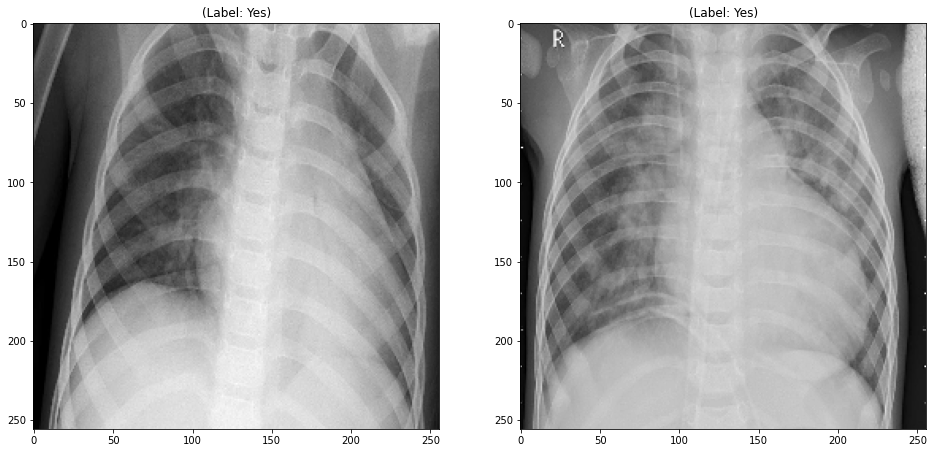

In [8]:
# Create dictionary of target classes
label_dict = {
 0: 'No',
 1: 'Yes'
}
plt.figure(figsize=[16,16])

# Display the first image in training data
plt.subplot(121)
curr_img = np.reshape(train_data[10], (image_size,image_size))
curr_lbl = train_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

# Display the first image in testing data
plt.subplot(122)
curr_img = np.reshape(test_data[10], (image_size,image_size))
curr_lbl = test_labels[10]
plt.imshow(curr_img, cmap='gray')
plt.title("(Label: " + str(label_dict[curr_lbl]) + ")")

In [9]:
train_data = train_data.reshape(-1, image_size,image_size, 1)
test_data = test_data.reshape(-1, image_size,image_size, 1)
train_data.shape, test_data.shape

((5216, 256, 256, 1), (624, 256, 256, 1))

In [10]:
train_data.dtype, test_data.dtype

(dtype('uint8'), dtype('uint8'))

In [11]:
np.max(train_data), np.max(test_data)

(255, 255)

In [12]:
train_data = train_data / np.max(train_data)
test_data = test_data / np.max(test_data)

In [13]:
np.max(train_data), np.max(test_data)

(1.0, 1.0)

In [14]:
from sklearn.model_selection import train_test_split
train_X,valid_X,train_ground,valid_ground = train_test_split(train_data,
                                                             train_data,
                                                             test_size=0.2,
                                                             random_state=13)

In [15]:

batch_size = 16
epochs = 32
inChannel = 1
x, y = image_size, image_size
input_img = Input(shape = (x, y, inChannel))
def encoder(input_img):
    #encoder
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img) #28 x 28 x 32
    conv1 = BatchNormalization()(conv1)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    conv1 = BatchNormalization()(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1) #14 x 14 x 32
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1) #14 x 14 x 64
    conv2 = BatchNormalization()(conv2)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    conv2 = BatchNormalization()(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2) #7 x 7 x 64
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2) #7 x 7 x 128 (small and thick)
    conv3 = BatchNormalization()(conv3)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    conv3 = BatchNormalization()(conv3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv3) #7 x 7 x 256 (small and thick)
    conv4 = BatchNormalization()(conv4)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    conv4 = BatchNormalization()(conv4)
    return conv4

def decoder(conv4):    
    #decoder
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv4) #7 x 7 x 128
    conv5 = BatchNormalization()(conv5)
    conv5 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv5)
    conv5 = BatchNormalization()(conv5)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv5) #7 x 7 x 64
    conv6 = BatchNormalization()(conv6)
    conv6 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv6)
    conv6 = BatchNormalization()(conv6)
    up1 = UpSampling2D((2,2))(conv6) #14 x 14 x 64
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(up1) # 14 x 14 x 32
    conv7 = BatchNormalization()(conv7)
    conv7 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = BatchNormalization()(conv7)
    up2 = UpSampling2D((2,2))(conv7) # 28 x 28 x 32
    decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(up2) # 28 x 28 x 1
    return decoded

In [16]:
autoencoder = Model(input_img, decoder(encoder(input_img)))
autoencoder.compile(loss='mean_squared_error', optimizer = RMSprop(lr=0.0005))

In [17]:
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 64)      18496 

In [18]:
autoencoder_train = autoencoder.fit(train_X, train_ground, batch_size=batch_size,epochs=epochs,verbose=2,validation_data=(valid_X, valid_ground))
autoencoder.save_weights("autoencoder"+str(image_size)+".h5")

Epoch 1/32
261/261 - 227s - loss: 0.0056 - val_loss: 0.0398
Epoch 2/32
261/261 - 210s - loss: 0.0021 - val_loss: 0.0085
Epoch 3/32
261/261 - 210s - loss: 0.0017 - val_loss: 0.0037
Epoch 4/32
261/261 - 210s - loss: 0.0015 - val_loss: 0.0040
Epoch 5/32
261/261 - 210s - loss: 0.0014 - val_loss: 0.0017
Epoch 6/32
261/261 - 209s - loss: 0.0013 - val_loss: 0.0020
Epoch 7/32
261/261 - 210s - loss: 0.0013 - val_loss: 0.0012
Epoch 8/32
261/261 - 210s - loss: 0.0011 - val_loss: 7.8345e-04
Epoch 9/32
261/261 - 210s - loss: 0.0011 - val_loss: 0.0028
Epoch 10/32
261/261 - 210s - loss: 0.0012 - val_loss: 9.3308e-04
Epoch 11/32
261/261 - 210s - loss: 0.0011 - val_loss: 9.7404e-04
Epoch 12/32
261/261 - 210s - loss: 0.0011 - val_loss: 6.6103e-04
Epoch 13/32
261/261 - 210s - loss: 0.0010 - val_loss: 7.6747e-04
Epoch 14/32
261/261 - 210s - loss: 0.0010 - val_loss: 5.8966e-04
Epoch 15/32
261/261 - 210s - loss: 0.0010 - val_loss: 8.1573e-04
Epoch 16/32
261/261 - 210s - loss: 9.4978e-04 - val_loss: 5.7232e-

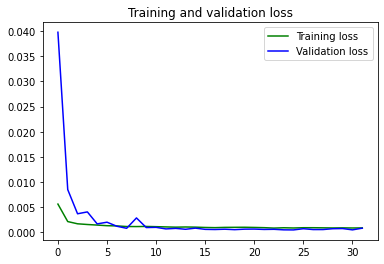

In [24]:

loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs_R = range(epochs)
plt.figure()
plt.plot(epochs_R, loss, 'g', label='Training loss')
plt.plot(epochs_R, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()


In [18]:
# Display the change for category label using one-hot encoding
print('Original label:', y_train[0])
print('After conversion to one-hot:', y_trainHot[0])

Original label: 1
After conversion to one-hot: [0. 1.]


In [19]:
autoencoder.load_weights("autoencoder"+str(image_size)+".h5")

In [20]:
train_X,valid_X,train_label,valid_label = train_test_split(train_data,y_trainHot,test_size=0.2,random_state=13)

In [21]:
train_X.shape,valid_X.shape,train_label.shape,valid_label.shape

((4172, 256, 256, 1), (1044, 256, 256, 1), (4172, 2), (1044, 2))

In [22]:
def fc(enco):
    flat = Flatten()(enco)
    den = Dense(128, activation='relu')(flat)
    out = Dense(1, activation='tanh')(den)
    return out
encode = encoder(input_img)
full_model = Model(input_img,fc(encode))

In [23]:
for l1,l2 in zip(full_model.layers[:19],autoencoder.layers[0:19]):
    l1.set_weights(l2.get_weights())

In [24]:
autoencoder.get_weights()[0][1]

array([[[-0.11219866, -0.06371037, -0.09626384,  0.11259838,
         -0.11218417, -0.1591926 ,  0.07295581, -0.07290497,
          0.12985979,  0.01542127, -0.0446111 , -0.08073704,
          0.08925854, -0.07602502, -0.05748515,  0.03416748,
          0.05165498, -0.21813127,  0.05675017,  0.03376954,
          0.26661548, -0.08153655, -0.05374327, -0.01566556,
         -0.07237345,  0.0314316 , -0.11071217,  0.08673395,
         -0.00724767,  0.0862444 , -0.10191729, -0.29499817]],

       [[ 0.11761583, -0.13860501,  0.04864473, -0.01447051,
          0.03367211,  0.21921961,  0.12772463,  0.04907383,
          0.14081295,  0.02524325,  0.19882509,  0.10412236,
          0.08898379, -0.09372793,  0.06963289, -0.28428736,
          0.04344307, -0.10585626,  0.25578046,  0.02985328,
          0.05901978, -0.13163804,  0.28708175,  0.06021185,
         -0.07426035,  0.07244967, -0.06852361,  0.19555655,
          0.21081364, -0.05028976,  0.03796182, -0.05766008]],

       [[-0.063425

In [25]:
full_model.get_weights()[0][1]

array([[[-0.11219866, -0.06371037, -0.09626384,  0.11259838,
         -0.11218417, -0.1591926 ,  0.07295581, -0.07290497,
          0.12985979,  0.01542127, -0.0446111 , -0.08073704,
          0.08925854, -0.07602502, -0.05748515,  0.03416748,
          0.05165498, -0.21813127,  0.05675017,  0.03376954,
          0.26661548, -0.08153655, -0.05374327, -0.01566556,
         -0.07237345,  0.0314316 , -0.11071217,  0.08673395,
         -0.00724767,  0.0862444 , -0.10191729, -0.29499817]],

       [[ 0.11761583, -0.13860501,  0.04864473, -0.01447051,
          0.03367211,  0.21921961,  0.12772463,  0.04907383,
          0.14081295,  0.02524325,  0.19882509,  0.10412236,
          0.08898379, -0.09372793,  0.06963289, -0.28428736,
          0.04344307, -0.10585626,  0.25578046,  0.02985328,
          0.05901978, -0.13163804,  0.28708175,  0.06021185,
         -0.07426035,  0.07244967, -0.06852361,  0.19555655,
          0.21081364, -0.05028976,  0.03796182, -0.05766008]],

       [[-0.063425

In [30]:
for layer in full_model.layers[0:19]:
    layer.trainable = False

In [31]:
full_model.compile(loss="binary_crossentropy", optimizer = Adam(),metrics=['accuracy'])

In [32]:
full_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 256, 256, 32)      320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 256, 256, 32)      9248      
_________________________________________________________________
batch_normalization_15 (Batc (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 128, 128, 64)      1849

In [ ]:
classify_train = full_model.fit(train_X, train_label, batch_size=16,epochs=100,verbose=2,validation_data=(valid_X, valid_label))
full_model.save_weights("autoencoder_classification"+str(image_size)+".h5")

Epoch 1/100
261/261 - 77s - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7123 - val_accuracy: 0.5000
Epoch 2/100
261/261 - 77s - loss: 7.7125 - accuracy: 0.5000 - val_loss: 7.7123 - val_accuracy: 0.5000
Epoch 3/100
